In [1]:
import re
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Результаты паракрана

Здесь можно подставить идентификатор любого другого паркрана.

In [2]:
parkrun = 'kuzminki'

Список идентификаторов всех российских паркранов находится в файле `russian_parkruns.csv`.

Какие результат получаем - последние или по конкретному номеру (закомментировать одну из строк с `suff`):

In [3]:
suff = '/latestresults/'  # результаты последнего паркрана, внесённого в систему

In [4]:
N = 100  # либо указываем номер и раскомментируем следующую строчку

In [5]:
#suff = f'/weeklyresults/?runSeqNumber={N}'

In [6]:
url = f'https://www.parkrun.ru/{parkrun}/results' + suff
page_all_results = requests.get(url, headers={'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:86.0) Gecko/20100101 Firefox/86.0'})

In [7]:
data = pd.read_html(page_all_results.text)[0]
unknown_runners = len(data[data['Участник'] == 'Неизвестный'])
data = data.dropna(thresh=3)

Количество "неизвестных" участников в данном забеге

In [8]:
unknown_runners

10

In [9]:
data['Позиция м/ж'] = data[data.columns[2]].dropna().transform(lambda s: re.search(r'(?:Мужской|Женский)[ ]+(\d+)', s)[1])
data[data.columns[2]] = data[data.columns[2]].dropna().transform(lambda s: re.search(r'Мужской|Женский', s)[0])

data[data.columns[1]] = data[data.columns[1]].transform(lambda s: re.search(r'([^\d]+)\d.*|Неизвестный', s)[1])

data[data.columns[3]] = data[data.columns[3]].dropna().transform(lambda s: re.search(r'\w\w\d\d-\d\d|ЮМ10|\w\w---', s)[0])

data['Личник'] = data[data.columns[5]].dropna().transform(lambda s: re.search(r'(?<=\d\d:\d\d)(.*)', s)[1])
data[data.columns[5]] = data[data.columns[5]].dropna().transform(lambda s: re.search(r'^(\d:)?\d\d:\d\d', s)[0])

#data['Клуб'].fillna('',inplace=True)

In [10]:
data

,Позиция,Участник,Пол,Возр. группа,Клуб,Время,Позиция м/ж,Личник
0,1,Виктор НИКОЛАЕВ,Мужской,СМ30-34,NaN,15:46,1,Новый ЛР!
1,2,Алексей КАТРЕНКО,Мужской,СМ30-34,NaN,17:23,2,Новый ЛР!
2,3,Александр ТАГАНЦЕВ,Мужской,СМ25-29,Парсек,18:06,3,ЛР 16:54
3,4,Владимир ИВАНОВ,Мужской,СМ25-29,NaN,18:46,4,ЛР 17:31
4,5,Leonardo GONZALEZ,Мужской,ВМ45-49,NaN,18:50,5,ЛР 18:40
...,...,...,...,...,...,...,...,...
149,150,Мария ЭЗАУ,Женский,СЖ20-24,NaN,38:01,47,ЛР 28:24
150,151,Анастасия САВЧЕНКО,Женский,СЖ20-24,NaN,42:14,48,Первый паркран!
151,152,Любовь КАЗАНЦЕВА,Женский,ВЖ55-59,NaN,49:47,49,ЛР 43:53
152,153,Андрей ЧИВИН,Мужской,ВМ40-44,Wake&Run,49:58,94,ЛР 18:27


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 153
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Позиция       144 non-null    int64 
 1   Участник      144 non-null    object
 2   Пол           144 non-null    object
 3   Возр. группа  144 non-null    object
 4   Клуб          44 non-null     object
 5   Время         144 non-null    object
 6   Позиция м/ж   144 non-null    object
 7   Личник        144 non-null    object
dtypes: int64(1), object(7)
memory usage: 10.1+ KB


In [12]:
data.isnull().sum()

Позиция           0
Участник          0
Пол               0
Возр. группа      0
Клуб            100
Время             0
Позиция м/ж       0
Личник            0
dtype: int64

## Распределение участников по полу

In [13]:
data['Пол'].value_counts()

Мужской    94
Женский    50
Name: Пол, dtype: int64

<AxesSubplot:xlabel='Пол', ylabel='count'>

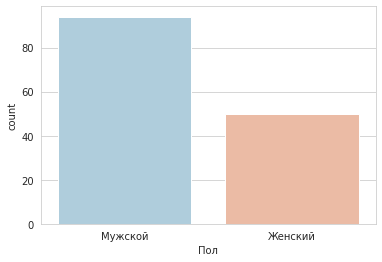

In [14]:
sns.set_style('whitegrid')
sns.countplot(x='Пол', data=data, palette='RdBu_r')

## Количество участников из беговых клубов

In [15]:
clubs = data['Клуб'].value_counts()

<AxesSubplot:xlabel='Клуб', ylabel='count'>

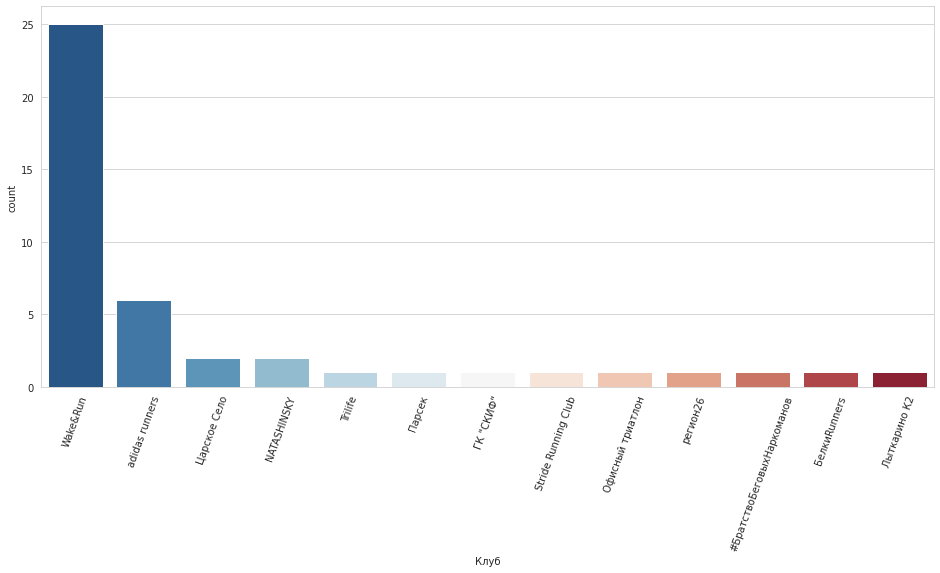

In [16]:
plt.figure(figsize=(16, 7))
plt.xticks(rotation=70)
sns.set_style('whitegrid')
sns.countplot(x='Клуб', data=data, palette='RdBu_r', order=clubs.index)

## Распределение по возрастным группам

In [17]:
data['Возр. группа'].value_counts()

СМ30-34    27
ВМ35-39    20
ВМ40-44    15
СЖ30-34    12
ВМ45-49     8
СЖ25-29     8
ВЖ35-39     8
ВЖ40-44     7
СМ25-29     7
СЖ20-24     6
ВМ60-64     4
ВЖ45-49     4
СМ20-24     3
ЮМ11-14     3
ВМ55-59     3
ЮЖ11-14     2
ВМ50-54     2
ВЖ60-64     1
ВМ65-69     1
ЮМ10        1
ВЖ55-59     1
СЖ18-19     1
Name: Возр. группа, dtype: int64

<AxesSubplot:xlabel='Пол', ylabel='count'>

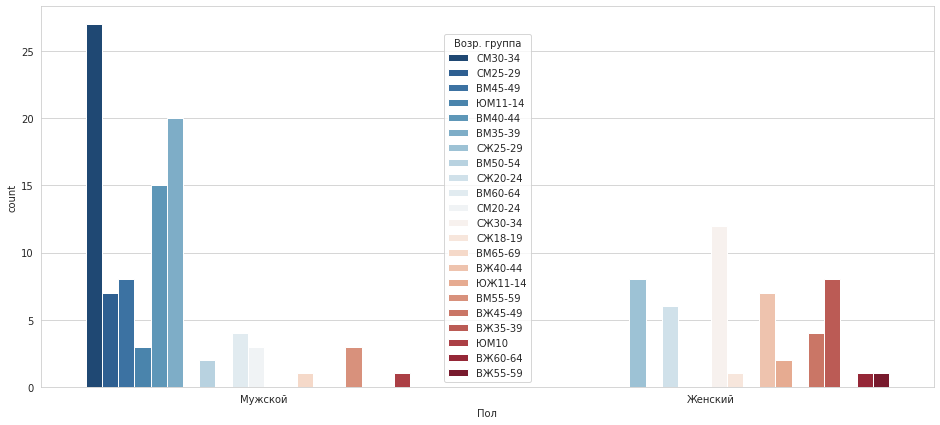

In [18]:
plt.figure(figsize=(16, 7))
sns.set_style('whitegrid')
sns.countplot(x='Пол', hue='Возр. группа', data=data, palette='RdBu_r')

### Распределение результатов участников

Text(0, 0.5, 'Количество результатов')

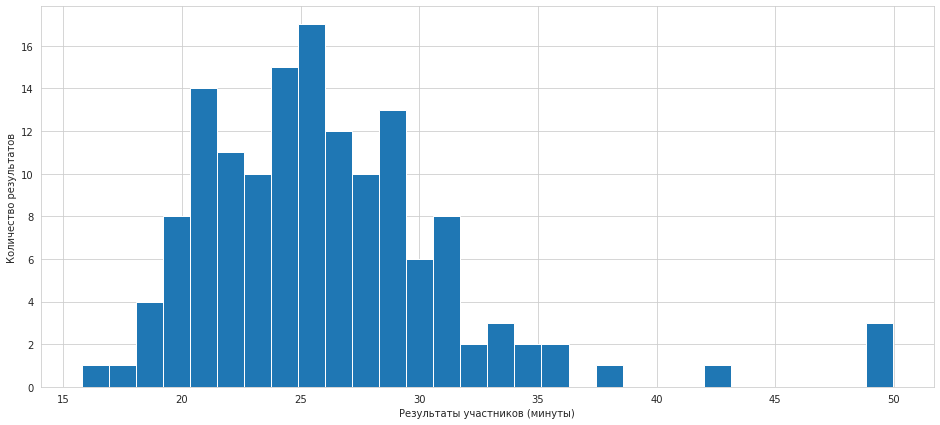

In [21]:
plt.figure(figsize=(16, 7))
ax = data['Время']\
.transform(lambda time: sum(x * int(t) for x, t in zip([1/60, 1, 60], time.split(':')[::-1])))\
.hist(bins=30)
ax.set_xlabel("Результаты участников (минуты)")
ax.set_ylabel("Количество результатов")